# Bayesian Gaussian Mixture Models - Semi-Supervised

### Conteúdo

- Determinar o número ideal de clusters usando pontuações GMM e BIC
- Estimar a importância do recurso
- Agrupe os dados usando votação suave
- Classificação usando as previsões confiáveis do agrupamento como rótulos de treinamento
- Classificação iterativa com classificador BGMM

### Referências
A inspiração foi tirada desses grandes cadernos:

- https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
- https://www.kaggle.com/code/ricopue/tps-jul22-clusters-and-lgb
- https://www.kaggle.com/code/pourchot/simple-soft-voting
- https://www.kaggle.com/code/hiro5299834/tps-jul-2022-unsupervised-and-supervised-learning
- https://www.kaggle.com/code/karlcini/bayesiangmmclassifier

Modelo de linha de base:

- https://www.kaggle.com/code/cabaxiom/tps-jul-22-gmm-baseline

# Preliminaries

In [1]:
#!pip install sklego

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklego.mixture import BayesianGMMClassifier

In [3]:
df = pd.read_csv("../Data/data.csv")
df = df.drop(columns="id")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

In [5]:
int_cols   = [i for i in df.columns if df[i].dtype == np.int64]
float_cols = [i for i in df.columns if df[i].dtype == np.float64]

In [6]:
print(int_cols) 
print(float_cols)

['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13']
['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']


# Preprocessing

In [7]:
transformer = PowerTransformer()
X_scaled = transformer.fit_transform(df)
X_scaled = pd.DataFrame(X_scaled, columns = df.columns)

In [8]:
X_scaled.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,-0.472922,-0.753925,-0.763110,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-0.423594,-0.088164,-1.777545,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652
2,0.805709,0.319397,-1.166935,-0.622421,0.108371,0.785018,1.990489,0.021718,1.017648,-0.394246,...,-0.408425,-1.598612,1.194423,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373
3,-0.500469,0.223997,0.262677,0.234061,0.417047,-1.218768,0.144455,0.286548,-1.213526,0.917564,...,0.620278,1.283827,0.532884,0.731623,-1.218086,0.826492,-1.173592,-0.395085,-0.100021,0.326682
4,-0.670427,-1.044482,-0.270854,-1.833338,-0.285955,-1.849243,0.787627,0.756900,0.187543,-0.394246,...,-1.614933,-0.432406,0.321899,0.228337,-1.482684,0.847999,-0.613935,1.164389,-0.374203,-1.160058


# Optimal Number of Clusters

We attempt to find the optimal number of clusters using a Gaussian Mixture Model. To do this we use the Bayesian Information Criterion (BIC), where our goal is to minimise the BIC score.

Tentamos encontrar o número ótimo de clusters usando um modelo de Gaussian Mixture. Para isso utilizamos o Critério de Informação Bayesiano (BIC), onde nosso objetivo é minimizar a pontuação do BIC.

In [9]:
def components_number_multiple(max_n, n_seeds):
    bic_scores = []
    for n in range(2,max_n):
        bic_scores_n = []
        for seed in range(n_seeds):
            gmm = GaussianMixture(n_components=n, covariance_type = 'full', n_init=3, random_state=seed)
            gmm.fit(X_scaled)
            bic_scores_n.append(gmm.bic(X_scaled))
            
        bic_scores.append(bic_scores_n)
        
    return bic_scores

In [10]:
def plot_components_number_multiple(max_n, n_seeds):
    
    bic_scores     = components_number_multiple(max_n + 1, n_seeds)
    bic_df         = pd.DataFrame(data = bic_scores).T
    bic_df.columns = range(2,max_n+1)
    
    f,ax = plt.subplots(figsize=(20,7))
    for i in range(n_seeds):
        sns.lineplot(x=bic_df.columns, y=bic_df.loc[i].values)
    ax.set_xticks(range(2,max_n+1))
    
    return bic_df

CPU times: total: 10min 33s
Wall time: 3min 35s


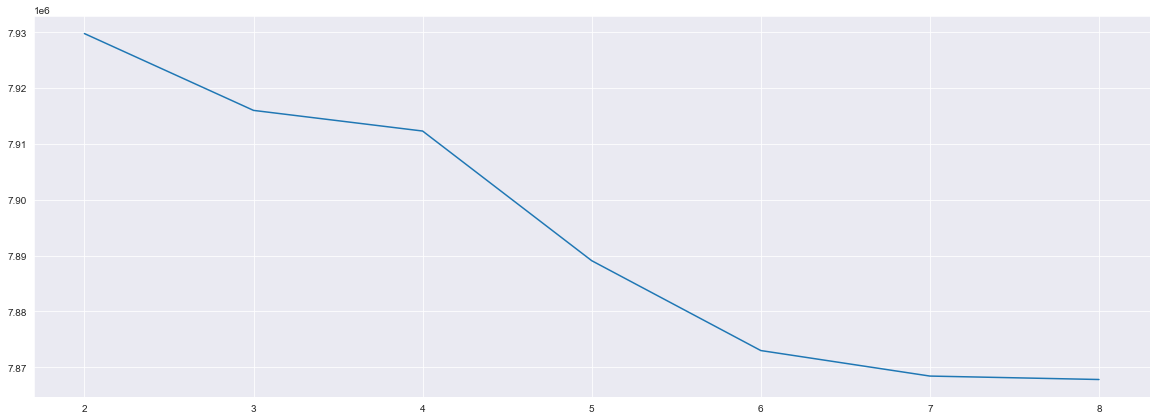

In [11]:
%%time 

a = plot_components_number_multiple(max_n = 8, n_seeds = 1)

Parece que 6 ou 7 é a melhor escolha para o número de clusters. Usamos 7.

# Feature Importance

Vamos encaixar um BGMM e dar uma olhada nos resultados:

In [14]:
bgmm            = BayesianGaussianMixture(n_components=7, covariance_type = 'full', n_init=3, random_state=2)
predicted_class = bgmm.fit_predict(X_scaled)
df["class"]     = predicted_class

In [15]:
X_scaled.shape

(98000, 29)

In [16]:
df.shape

(98000, 30)

## Visualising Feature Importance

raçamos um gráfico mostrando as distribuições de cada recurso - com cada gráfico mostrando a distribuição de cada classe. Quanto mais distintas forem as diferentes distribuições de classes, mais útil será esse recurso.

### Float features

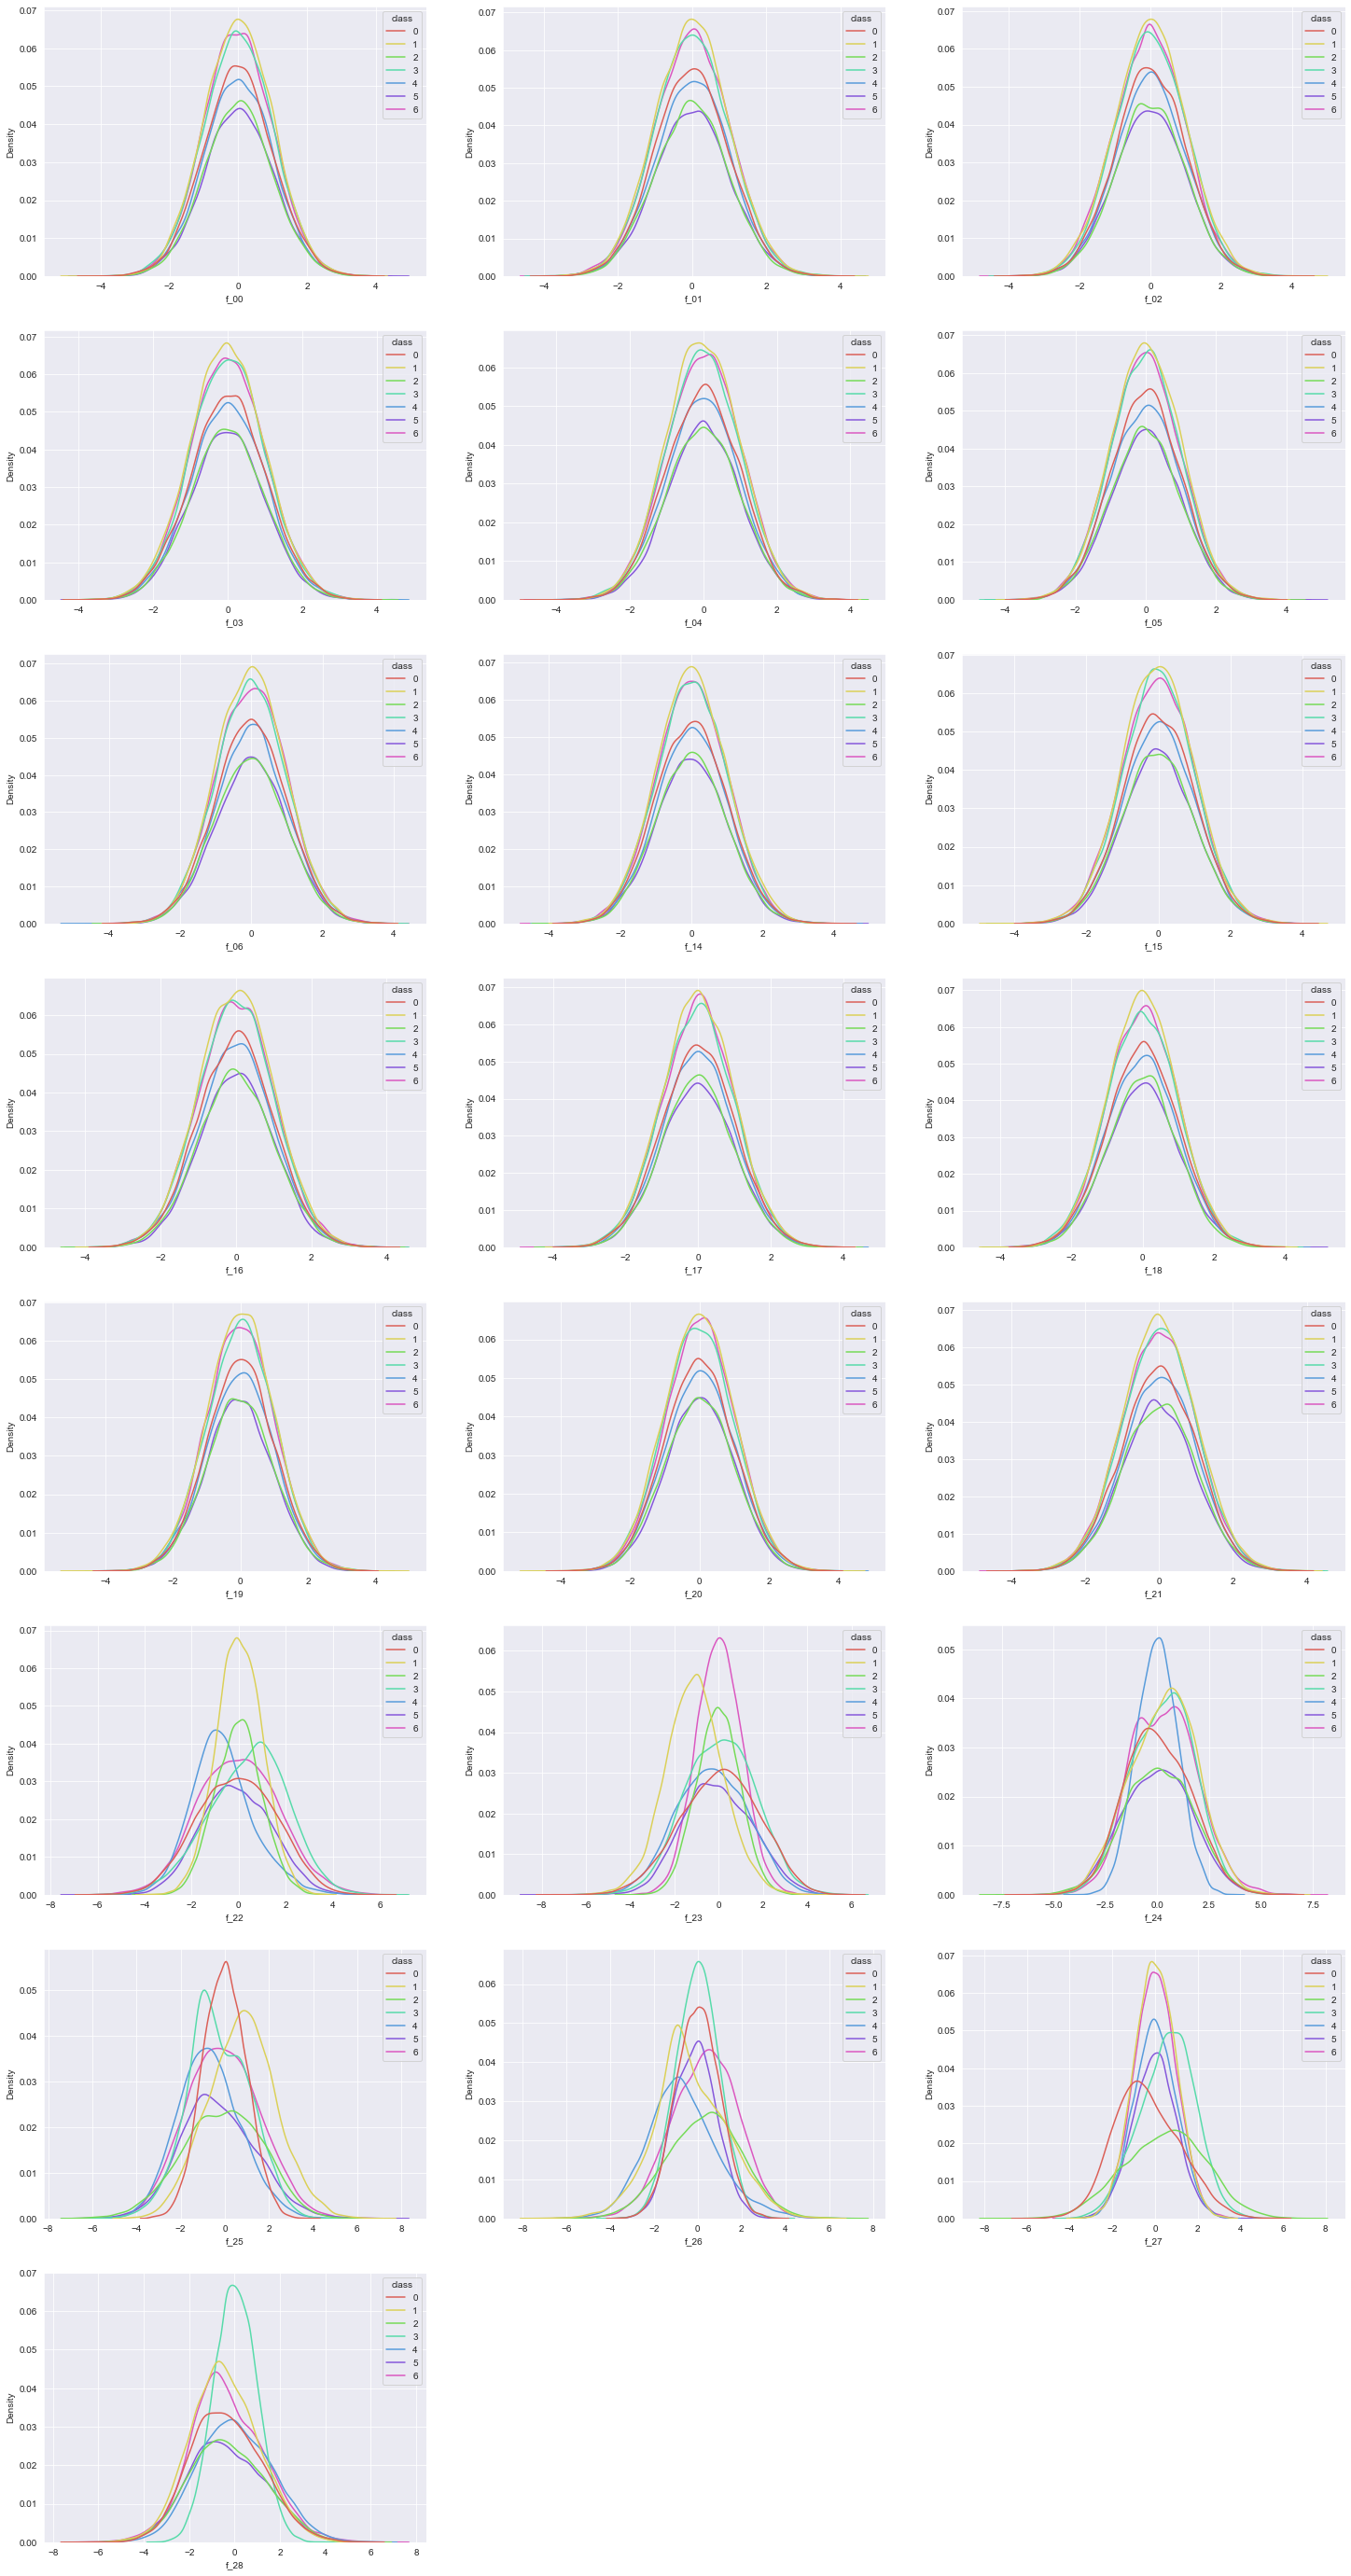

In [18]:
f,ax = plt.subplots(figsize=(25,50))
for n,feature in enumerate(float_cols):
    plt.subplot(8,3,n+1)
    sns.kdeplot(data=df, x=feature, hue="class", palette=sns.color_palette("hls", 7));

### Integer features

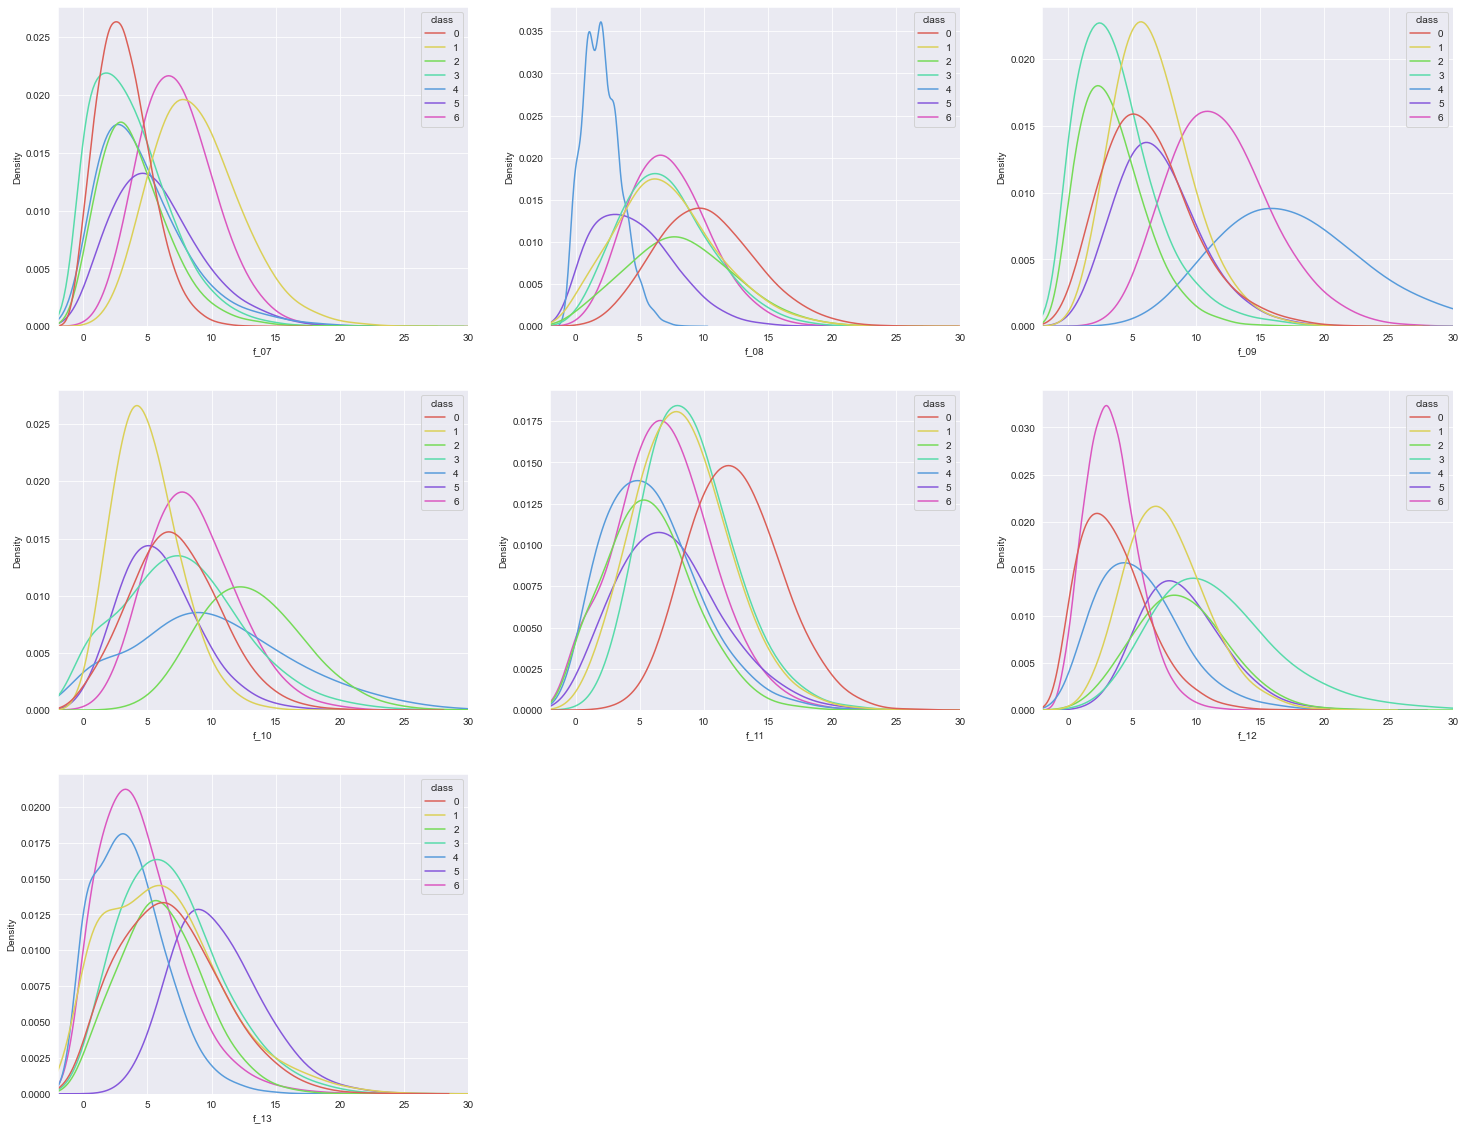

In [18]:
f,ax = plt.subplots(figsize=(25,20))
for n,feature in enumerate(int_cols):
    ax = plt.subplot(3,3,n+1)
    sns.kdeplot(data=df, x=feature, hue="class", bw_adjust=2, palette=sns.color_palette("hls", 7));
    ax.set_xlim([-2,30])

### Select Best Columns

Com base nos gráficos acima:

- Todos os recursos inteiros parecem importantes \[`f_07`, `f_08`, ..., `f_13`\]
- Os recursos float \[`f_22`, `f_23`, ... , `f_28`\] parecem importantes, mas os outros recursos float não.

Quando treinarmos novamente nosso modelo, usaremos apenas esses recursos importantes.

In [27]:
best_cols = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 
             'f_24', 'f_25','f_26','f_27', 'f_28']

# Clustering

Antes de agrupar, é útil poder avaliar o desempenho de nossas previsões de agrupamento.

Para avaliar o desempenho do cluster sem rótulos de verdade, podemos usar:

**Coeficiente de silhueta**

A pontuação é maior quando os clusters são densos e bem separados, o que se relaciona a um conceito padrão de cluster.

A pontuação é limitada entre -1 para agrupamento incorreto e +1 para agrupamento altamente denso. Pontuações em torno de zero indicam clusters sobrepostos.

https://scikit-learn.org/stable/modules/clustering.html#silhouette-coeficiente

**Índice Calinski-Harabasz**

A pontuação é maior quando os clusters são densos e bem separados

https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index

**Índice Davies-Bouldin**

O índice Davies-Bouldin mais baixo refere-se a um modelo com melhor separação entre o cluster

https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index


In [28]:
def score_clusters(X, predictions, silhouette = True, verbose=False):
    """Evaluate how good our cluster label predictions are"""
    
    db_score = davies_bouldin_score(X=X, labels=predictions)

    ch_score = calinski_harabasz_score(X=X, labels=predictions)
    #the silhouette score is the slowest to compute ~90 secs
    s_score = silhouette_score(X=X, labels=predictions, metric='euclidean')
    
    if verbose:
        print("David Bouldin score: {0:0.4f}".format(db_score))
        print("Calinski Harabasz score: {0:0.3f}".format(ch_score))
        print("Silhouette score: {0:0.4f}".format(s_score))
        
    return db_score, ch_score, s_score

(Bayesian) Modelos de mistura gausiana podem gerar probabilidades, então ajustamos o modelo várias vezes com diferentes sementes aleatórias e somamos as probabilidades previstas. A classe com a maior probabilidade prevista será então usada para a tarefa final da classe (votação suave).

O principal desafio na implementação disso é que cada vez que ajustamos o modelo, o modelo produzirá diferentes rótulos de cluster. Para contornar isso, calculamos a distância entre os centróides do cluster do primeiro modelo e os centróides do cluster de cada modelo subsequentemente ajustado. O centroide do cluster de uma classe estará em locais semelhantes cada vez que o modelo for ajustado, mesmo que o rótulo atribuído aleatoriamente para esse cluster possa ser diferente. Podemos usar essas informações para garantir que sejamos consistentes com as atribuições de rótulo de cluster do primeiro modelo ajustado. Esta não é uma solução perfeita, pois depende dos centróides do cluster estarem em locais semelhantes para cada ajuste (B)GMM, mas parece suficiente.


In [ ]:
#def soft_voting(predict_number, best_cols = best_cols):
 
best_cols = ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 
             'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 
             'f_25', 'f_26', 'f_27', 'f_28']

predict_number = 2  
best_cols      = best_cols

# inicializar dataframe com 0's
predicted_probabilities = pd.DataFrame(np.zeros((len(df),7)), columns=range(1,8))

# loop com sementes aleatórias diferentes
for i in range(predict_number):
    
    print("=========", i, "==========")
    X_scaled_sample = X_scaled.sample(40000)
    gmm = BayesianGaussianMixture(n_components    = 7, 
                                  covariance_type = 'full', 
                                  max_iter        = 300, 
                                  init_params     = "kmeans", 
                                  n_init          = 3, 
                                  random_state    = i)
    
    gmm.fit(X_scaled_sample[best_cols])
    
    pred_probs = gmm.predict_proba(X_scaled[best_cols])
    pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))

    # garantindo que os clusters sejam rotulados com o mesmo valor em cada ajuste
    if i == 0:
        initial_centers = gmm.means_
        
    new_classes = []
    
    for mean2 in gmm.means_:
        #para o centro atual do gmm atual, encontre as distâncias para cada centro no gmm inicial
        distances = [np.linalg.norm(mean1-mean2) for mean1 in initial_centers]
        
        # selecione a classe com a distância mínima
        new_class = np.argmin(distances) + 1 #add 1 as our labels are 1-7 but index is 0-6
        new_classes.append(new_class)
        
    # se o mapeamento de rótulos de cluster antigos para novos rótulos de cluster não for de 1 para 1
    if len(new_classes) != len(set(new_classes)):
        print("iteration", i, "could not determine the cluster label mapping, skipping")
        continue
        
    #apply the mapping by renaming the dataframe columns representing the original labels to the new labels    
    pred_probs = pred_probs.rename(columns=dict(zip(range(1,8),new_classes)))

    #add the current prediction probabilities to the overall prediction probabilities
    predicted_probabilities = predicted_probabilities + pred_probs
    # lets score the cluster labels each iteration to see if soft voting is helpful
    score_clusters(X_scaled[best_cols], predicted_probabilities.idxmax(axis=1), verbose=True)

#normalise dataframe so each row sums to 1
predicted_probabilities = predicted_probabilities.div(predicted_probabilities.sum(axis=1), axis=0)
#    return predicted_probabilities


In [35]:
def soft_voting(predict_number, best_cols = best_cols):
    #initialise dataframe with 0's
    predicted_probabilities = pd.DataFrame(np.zeros((len(df),7)), columns=range(1,8))
    # loop with a different random seeds
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = X_scaled.sample(40000)
        gmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full', max_iter=300, init_params="kmeans", n_init=3, random_state=i)
        gmm.fit(X_scaled_sample[best_cols])
        pred_probs = gmm.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # ensuring clusters are labeled the same value at each fit
        if i == 0:
            initial_centers = gmm.means_
        new_classes = []
        for mean2 in gmm.means_:
            #for the current center of the current gmm, find the distances to every center in the initial gmm
            distances = [np.linalg.norm(mean1-mean2) for mean1 in initial_centers]
            # select the class with the minimum distance
            new_class = np.argmin(distances) + 1 #add 1 as our labels are 1-7 but index is 0-6
            new_classes.append(new_class)
        # if the mapping from old cluster labels to new cluster labels isn't 1 to 1
        if len(new_classes) != len(set(new_classes)):
            print("iteration", i, "could not determine the cluster label mapping, skipping")
            continue
        #apply the mapping by renaming the dataframe columns representing the original labels to the new labels    
        pred_probs = pred_probs.rename(columns=dict(zip(range(1,8),new_classes)))
        
        #add the current prediction probabilities to the overall prediction probabilities
        predicted_probabilities = predicted_probabilities + pred_probs
        # lets score the cluster labels each iteration to see if soft voting is helpful
        score_clusters(X_scaled[best_cols], predicted_probabilities.idxmax(axis=1), verbose=True)
    
    #normalise dataframe so each row sums to 1
    predicted_probabilities = predicted_probabilities.div(predicted_probabilities.sum(axis=1), axis=0)
    return predicted_probabilities

In [37]:
pred_probs = soft_voting(30)

========= 0 ==========
David Bouldin score: 3.7201
Calinski Harabasz score: 3901.204
Silhouette score: 0.0387
========= 1 ==========
David Bouldin score: 3.6596
Calinski Harabasz score: 3830.665
Silhouette score: 0.0367
========= 2 ==========
David Bouldin score: 3.6267
Calinski Harabasz score: 3813.818
Silhouette score: 0.0360
========= 3 ==========
David Bouldin score: 3.6308
Calinski Harabasz score: 3807.887
Silhouette score: 0.0359
========= 4 ==========
David Bouldin score: 3.6263
Calinski Harabasz score: 3809.227
Silhouette score: 0.0359
========= 5 ==========
David Bouldin score: 3.6266
Calinski Harabasz score: 3806.875
Silhouette score: 0.0357
========= 6 ==========
David Bouldin score: 3.6210
Calinski Harabasz score: 3810.136
Silhouette score: 0.0357
========= 7 ==========
David Bouldin score: 3.6200
Calinski Harabasz score: 3807.710
Silhouette score: 0.0357
========= 8 ==========
David Bouldin score: 3.6266
Calinski Harabasz score: 3807.605
Silhouette score: 0.0358
========= 

In [23]:
def best_class(df):
    new_df = df.copy()
    new_df["highest_prob"] = df.max(axis=1)
    new_df["best_class"]   = df.idxmax(axis=1)
    new_df["second_highest_prob"] = df.apply(lambda x: x.nlargest(2).values[-1], axis=1)
    new_df["second_best_class"]   = df.apply(lambda x: np.where(x == x.nlargest(2).values[-1])[0][0]+1, axis=1)
    return new_df

In [24]:
cluster_class_probs = best_class(pred_probs)

In [25]:
cluster_class_probs.head()

,1,2,3,4,5,6,7,highest_prob,best_class,second_highest_prob,second_best_class
0,0.007166,7.648215e-07,0.005026,0.980587,0.002838,0.000005,0.004377,0.980587,4,0.007166,1
1,0.635081,4.157350e-02,0.002298,0.001637,0.065767,0.253452,0.000191,0.635081,1,0.253452,6
2,0.000134,5.023474e-08,0.000701,0.720469,0.001320,0.000027,0.277349,0.720469,4,0.277349,7
3,0.021762,8.054510e-01,0.000029,0.000022,0.059482,0.000006,0.113248,0.805451,2,0.113248,7
4,0.000086,2.162307e-06,0.000732,0.000004,0.998946,0.000188,0.000043,0.998946,5,0.000732,3


Vamos visualizar o quão confiantes são nossas previsões:

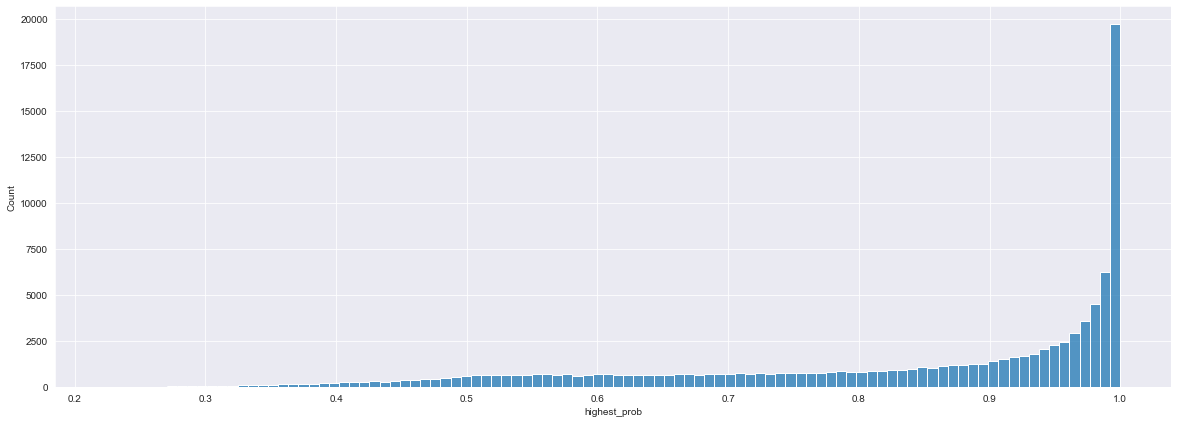

In [26]:
f,ax = plt.subplots(figsize=(20,7))
sns.histplot(cluster_class_probs["highest_prob"], bins=100);

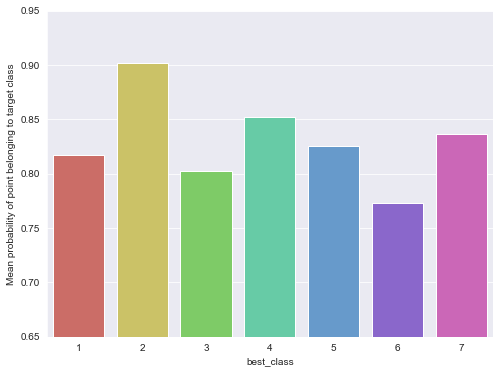

In [27]:
confidence_s = cluster_class_probs.groupby("best_class")["highest_prob"].mean()
f,ax = plt.subplots(figsize=(8,6))
sns.barplot(x=confidence_s.index, y = confidence_s.values, palette=sns.color_palette("hls", 7) );
ax.set_ylabel("Mean probability of point belonging to target class");
ax.set_ylim([0.65,0.95]);

Permite visualizar quais clusters são comumente confundidos entre si

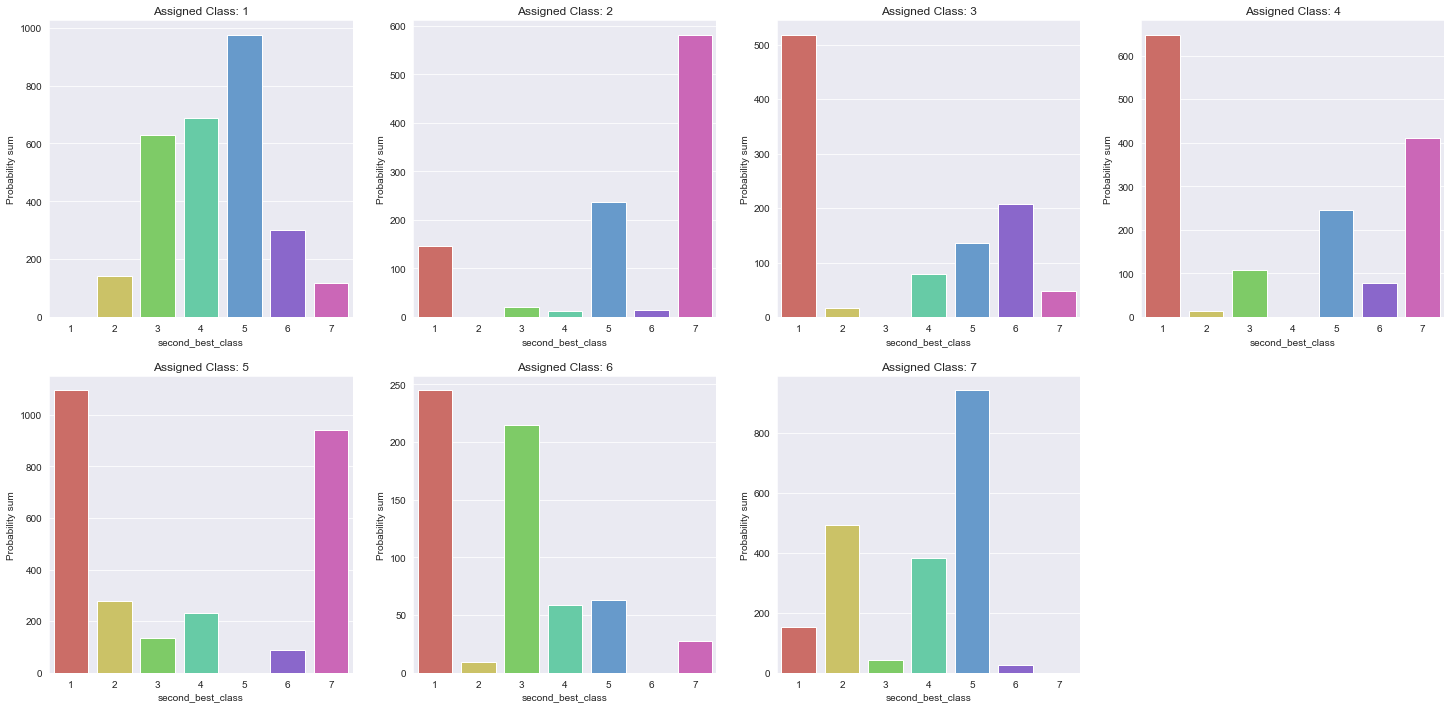

In [28]:
second_highest_probs_sum = cluster_class_probs.groupby(["best_class","second_best_class"])["second_highest_prob"].sum().reset_index()

f,ax = plt.subplots(figsize=(25,12))
format_dataframe = pd.DataFrame({"second_best_class":range(1,8)})
for i in range(1,8):
    second_best_match_for_i = second_highest_probs_sum.loc[second_highest_probs_sum["best_class"] == i, ["second_best_class","second_highest_prob"]]
    #We merge so that all classes 1 to 7 are available, we do this to keep colours consistent throughout plots
    plot_df = pd.merge(left=format_dataframe, right=second_best_match_for_i, how="left", on="second_best_class")
    ax = plt.subplot(2,4,i)
    sns.barplot(data= plot_df, x="second_best_class", y="second_highest_prob",palette=sns.color_palette("hls", 7) );
    ax.set_ylabel("Probability sum")
    ax.set_title("Assigned Class: " + str(i))



# Classification

Adotamos uma abordagem semi-supervisionada para este desafio de agrupamento.

Para fazer isso, ajustamos nosso modelo de classificação usando pontos em que o algoritmo de agrupamento estava confiante de que estava correto. Podemos então usar o modelo de classificação para prever os pontos em que não estava confiante de que estava correto.

A esperança é que o algoritmo de classificação seja melhor que o algoritmo de agrupamento. Se isso for verdade, podemos confiar mais nas previsões dos algoritmos de classificação do que nas previsões dos algoritmos de agrupamento e melhorar nossa pontuação.

In [29]:
confident_predictions = cluster_class_probs.loc[cluster_class_probs["highest_prob"] >= 0.85]
confident_predictions_class = confident_predictions["best_class"]
X_scaled["class"] = confident_predictions_class

In [30]:
train_df = X_scaled.loc[X_scaled["class"] == X_scaled["class"]]
test_df = X_scaled.loc[X_scaled["class"] != X_scaled["class"]]

In [31]:
X = train_df.drop(columns="class").reset_index(drop=True)
y = train_df["class"].reset_index(drop=True)
X_test = test_df.drop(columns="class").reset_index(drop=True)
X_full = X_scaled.drop(columns="class")

## Cross Validation

Lets see how well the classification algorithms perform. The results might be a bit biased as we are evaluating using labels that the clustering algorithm was confident with, it will be much harder for the algorithm to predict the points the clustering algorithm was not confident with.

### Define models

In [32]:
model_et = ExtraTreesClassifier(n_estimators = 2000,
                                n_jobs = -1,
                                random_state=42
                               )

In [33]:
model_lgbm = LGBMClassifier(objective = 'multiclass',
                            n_estimators = 5000,
                            random_state = 42,
                            learning_rate = 0.1,
                            n_jobs = -1)

In [34]:
model_qda = QuadraticDiscriminantAnalysis()
model_lda = LinearDiscriminantAnalysis()

In [36]:
model_bgmm = BayesianGMMClassifier(
            n_components=7,
            random_state = 1,
            tol =1e-3,
            covariance_type = 'full',
            max_iter = 400,
            n_init=4,
            init_params='kmeans')

In [37]:
models = {"ET":model_et, "LGBM":model_lgbm, "QDA":model_qda, "LDA":model_lda, "BGMM_C":model_bgmm}

### Compare Classificatin performance

In [38]:
def k_fold_cv(model,X,y, verbose=True):
    kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 0)

    feature_imp, y_pred_list, y_true_list, acc_list  = [],[],[],[]
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        if verbose: print("==fold==", fold)
        X_train = X.loc[train_index]
        X_val = X.loc[val_index]

        y_train = y.loc[train_index]
        y_val = y.loc[val_index]

        model.fit(X_train,y_train)

        y_pred = model.predict(X_val)

        y_pred_list = np.append(y_pred_list, y_pred)
        y_true_list = np.append(y_true_list, y_val)

        acc_list.append(accuracy_score(y_pred, y_val))
        if verbose: print('Acc', accuracy_score(y_pred, y_val))

        try:
            feature_imp.append(model.feature_importances_)
        except AttributeError: # if model does not have .feature_importances_ attribute
            pass # returns empty list
            
    return feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val

In [39]:
def evaluate_models():
    for model_name, model in models.items():
        print("===",model_name,"===")
        feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=model,X=X,y=y, verbose=False)
        acc_score = accuracy_score(y_pred_list, y_true_list)
        print("{0:0.4f}".format(acc_score))

In [42]:
X.shape

(59087, 29)

In [40]:
evaluate_models()

=== ET ===


KeyboardInterrupt: 

Just because a classification model performs better than another does not mean the clustering labels will be better. This is because the train/validation data is from a different distribution from the test data (as we select points in the train/val datasets that are BGMM was confident in predicting) so models that generalise well may outperform those with a high accuracy on the validation set.

### Feature importance

Lets just reconfirm that the features we dropped in the clustering algorithm are also not important for the classification algorithm.

In [ ]:
feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=model_lgbm,X=X,y=y)

In [ ]:
def fold_feature_importances(model_importances, column_names, model_name, n_folds = 5, ax=None, boxplot=False):
    importances_df = pd.DataFrame({"feature_cols": column_names, "importances_fold_0": model_importances[0]})
    for i in range(1,n_folds):
        importances_df["importances_fold_"+str(i)] = model_importances[i]
    importances_df["importances_fold_median"] = importances_df.drop(columns=["feature_cols"]).median(axis=1)
    importances_df = importances_df.sort_values(by="importances_fold_median", ascending=False)
    if ax == None:
        f, ax = plt.subplots(figsize=(15, 25))
    if boxplot == False:
        ax = sns.barplot(data = importances_df, x = "importances_fold_median", y="feature_cols", color="blue")
        ax.set_xlabel("Median Feature importance across all folds");
    elif boxplot == True:
        importances_df = importances_df.drop(columns="importances_fold_median")
        importances_df = importances_df.set_index("feature_cols").stack().reset_index().rename(columns={0:"feature_importance"})
        ax = sns.boxplot(data = importances_df, y = "feature_cols", x="feature_importance", color="blue", orient="h")
        ax.set_xlabel("Feature importance across all folds");
    plt.title(model_name)
    ax.set_ylabel("Feature Columns")
    return ax

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
fold_feature_importances(model_importances = feature_imp, column_names = X_val.columns, model_name = "LGBM", n_folds = 2, ax=ax, boxplot=False);

Yep as expected, \[`f_07`, `f_08`, ..., `f_13`\] and \[`f_22`, `f_23`, ... , `f_28`\] seem important, but the other features do not.

## Inference

In [ ]:
def fit_predict_all():
    predictions = []
    model_names = []
    scores = []
    for model_name, model in models.items():
        print("===",model_name,"===")
        model.fit(X[best_cols], y)
        preds_prob =  model.predict_proba(X_full[best_cols])
        preds_prob_df = pd.DataFrame(preds_prob, columns=range(1,8), index=X_scaled.index)
        db, ch, s = score_clusters(X_scaled[best_cols], preds_prob_df.idxmax(axis=1), verbose=True)
        scores.append((db,ch,s))
        predictions.append(preds_prob_df)
        model_names.append(model_name)
    
    return predictions, model_names, scores
    

In [ ]:
predictions, model_names, scores = fit_predict_all()

Lets compare these scores to our clustering scores and also add our clustering predictions to the list of classification predictions

In [ ]:
cluster_class_probs = cluster_class_probs.loc[:,[1,2,3,4,5,6,7]]

In [ ]:
predictions.append(cluster_class_probs)
model_names.append("BGMM")

In [ ]:
db, ch, s = score_clusters(X_scaled[best_cols], cluster_class_probs.idxmax(axis=1), verbose=True)
scores.append((db,ch,s))

Our classification algorithm appears to be performing better than our clustering algorithms; although I don't trust the clustering scores too much.

## Combine Predictions

Lets combine the probabilities from the different classification/clustering algorithms.

In [ ]:
#chosen fairly randomly
predictions_df = 0.5 * predictions[0] + 1.5 * predictions[1] + 0.5 * predictions[2] + 1.5 * predictions[4] + 0.5 * predictions[5]

#normalise so rows sums to 1
predictions_df = predictions_df.div(predictions_df.sum(axis=1), axis=0)
predictions_df = best_class(predictions_df)

In [ ]:
db, ch, s = score_clusters(X_scaled[best_cols], predictions_df["best_class"], verbose=True)
scores.append((db,ch,s))
model_names.append("combined")

In [ ]:
pd.DataFrame(scores, index=model_names, columns=["Davies-Bouldin Index","Calinski-Harabasz Index","Silhouette Coefficient"])

Just because a model has good evaluation clustering scores, does not necessarily mean it will have a better leaderboard score. LDA for example has the best evaluation scores, but has the worst leaderboard score.

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values);

In [ ]:
pca = PCA(random_state = 10)
X_pca = pca.fit_transform(X_scaled[best_cols])
PCA_df = pd.DataFrame({"PCA_1" : X_pca[:,0], "PCA_2" : X_pca[:,1]})   
PCA_df["class"] = predictions_df["best_class"]
    
f,ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = PCA_df, x = "PCA_1", y = "PCA_2", hue="class", s=2, palette=sns.color_palette("hls", PCA_df["class"].nunique()));

In [ ]:
confidence_s = predictions_df.groupby("best_class")["highest_prob"].mean()
f,ax = plt.subplots(figsize=(8,6))
sns.barplot(x=confidence_s.index, y = confidence_s.values, palette=sns.color_palette("hls", 7) );
ax.set_ylabel("Mean probability of point belonging to target class");
ax.set_ylim([0.4,0.95]);

In [ ]:
second_highest_probs_sum = predictions_df.groupby(["best_class","second_best_class"])["second_highest_prob"].sum().reset_index()

f,ax = plt.subplots(figsize=(25,12))
format_dataframe = pd.DataFrame({"second_best_class":range(1,8)})
for i in range(1,8):
    second_best_match_for_i = second_highest_probs_sum.loc[second_highest_probs_sum["best_class"] == i, ["second_best_class","second_highest_prob"]]
    #We merge so that all classes 1 to 7 are available, we do this to keep colours consistent throughout plots
    plot_df = pd.merge(left=format_dataframe, right=second_best_match_for_i, how="left", on="second_best_class")
    ax = plt.subplot(2,4,i)
    sns.barplot(data= plot_df, x="second_best_class", y="second_highest_prob",palette=sns.color_palette("hls", 7) );
    ax.set_ylabel("Probability sum")
    ax.set_title("Assigned Class: " + str(i))



# Iterative Classification - BGMM Classifier

To improve performance further we can iteratively use the the predicted labels from the previous iteration's model as our training labels for the current iteration's model.

In [ ]:
def update_predictions(predict_number, y):
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = X_scaled.sample(60000)
        y_sample = y.loc[X_scaled_sample.index]
        
        bgmmC = BayesianGMMClassifier(
        n_components=7,
        random_state = i,
        tol =1e-3,
        covariance_type = 'full',
        max_iter = 300,
        n_init=3,
        init_params='kmeans')
        
        bgmmC.fit(X_scaled_sample[best_cols], y_sample)
        
        pred_probs = bgmmC.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # lets score the cluster labels each iteration
        score_clusters(X_scaled[best_cols], pred_probs.idxmax(axis=1), verbose=True)
        y = pred_probs.idxmax(axis=1)
        
    return pred_probs

In [ ]:
predicted_probabilities = update_predictions(predict_number=25, y=predictions_df["best_class"])

The clustering scores are getting worse each iteration, but the leaderboard performance improves.

In [ ]:
predictions_df = best_class(predicted_probabilities)

In [ ]:
second_highest_probs_sum = predictions_df.groupby(["best_class","second_best_class"])["second_highest_prob"].sum().reset_index()

f,ax = plt.subplots(figsize=(25,12))
format_dataframe = pd.DataFrame({"second_best_class":range(1,8)})
for i in range(1,8):
    second_best_match_for_i = second_highest_probs_sum.loc[second_highest_probs_sum["best_class"] == i, ["second_best_class","second_highest_prob"]]
    #We merge so that all classes 1 to 7 are available, we do this to keep colours consistent throughout plots
    plot_df = pd.merge(left=format_dataframe, right=second_best_match_for_i, how="left", on="second_best_class")
    ax = plt.subplot(2,4,i)
    sns.barplot(data= plot_df, x="second_best_class", y="second_highest_prob",palette=sns.color_palette("hls", 7) );
    ax.set_ylabel("Probability sum")
    ax.set_title("Assigned Class: " + str(i))

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values);

# Submission

In [ ]:
submission = pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")

In [ ]:
submission["Predicted"] = predictions_df["best_class"]
submission.to_csv('submission.csv', index=False)